# Comparison ATL03, ATL08, ATL12, and ATL13

## Data downloaded with Open Altimetry

## Computing environment

We'll be using the following Python libraries in this notebook:

In [1]:
%matplotlib widget
import os
import ee
import geemap
import requests
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
from datetime import timedelta
import rasterio as rio
from rasterio import plot
from rasterio import warp

    
The import below is a class that the organizers wrote. It helps us read and store data from the OpenAltimetry API.  This line is importing the class `dataCollector` in the file `oa.py` in the `utils` folder.

In [3]:
from utils.oa import dataCollector

## Get data URL from the OpenAltimetry API

* Go to [openaltimetry.org](https://openaltimetry.org/)
* Select **BROWSE ICESAT-2 DATA**. 
* Select **ATL 08** on the left
* Select a date
* Click **SELECT A REGION** on the top left, and drew a rectangle
* Right click on the rectangle and select **View Elevation profile**. This opens a pop up, and shows ATL06 and ATL08 elevations. 
* Scroll to the **bottom** and select **Get API URL**. Copy it.

We can now initialize a `dataCollector` object, using the copy-pasted OpenAltimetry API URL, and the beam we would like to look at. 

Note, we don't need EarthData credentials for this.

In [4]:
url = 'http://openaltimetry.org/data/api/icesat2/atl13?date=2020-12-15&minx=-77.858681&miny=25.728091&maxx=-77.831461&maxy=25.832559&trackId=1254&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt1r'
is2data = dataCollector(oaurl=url, beam=gtx, verbose=True)

OpenAltimetry API URL: http://openaltimetry.org/data/api/icesat2/atlXX?date=2020-12-15&minx=-77.858681&miny=25.728091&maxx=-77.831461&maxy=25.832559&trackId=1254&outputFormat=json&beamName=gt1r&client=jupyter
Date: 2020-12-15
Track: 1254
Beam: gt1r
Latitude limits: [25.728091, 25.832559]
Longitude limits: [-77.858681, -77.831461]


### Another way to get the OA URL


Alternatively, we could use a date, track number, beam, and lat/lon bounding box as input to the `dataCollector`.

In [5]:
latlims = [-70.34957, -70.24491]
lonlims = [12.10769, 12.42636]
rgt = 312 # track number
gtx = 'gt2r' # The beam
date = '2020-01-16'
is2data = dataCollector(date=date, latlims=latlims, lonlims=lonlims, track=rgt, beam=gtx, verbose=True)

OpenAltimetry API URL: https://openaltimetry.org/data/api/icesat2/atlXX?date=2020-01-16&minx=12.10769&miny=-70.34957&maxx=12.42636&maxy=-70.24491&trackId=312&beamName=gt2r&outputFormat=json&client=jupyter
Date: 2020-01-16
Track: 312
Beam: gt2r
Latitude limits: [-70.34957, -70.24491]
Longitude limits: [12.10769, 12.42636]


Note that this also constructs the API url for us.

### Requesting the data from the OpenAltimetry API
Here we use the `requestData()` function of the `dataCollector` class, which is defined in `utils/oa.py`. It downloads ATL03, ATL06 and ATL08 data based on the inputs with which we initialized our `dataCollector`, and writes them to pandas dataframes.

In [ ]:
is2data.requestData(verbose=True)

The data are now stored as data frames in our `dataCollector` object. To verify this, we can run the cell below.

In [ ]:
vars(is2data)

## Plotting the ATL03, ATL06 and ATL08 data

To make plots easier to produce, the `dataCollector` class in `utils/oa.py` has a method to plot the data that we downloaded. 

Data has not yet been requested from OpenAltimetry yet. Doing this now.
---> requesting ATL03 data... Done.
---> requesting ATL06 data... Done.
---> requesting ATL08 data... Done.


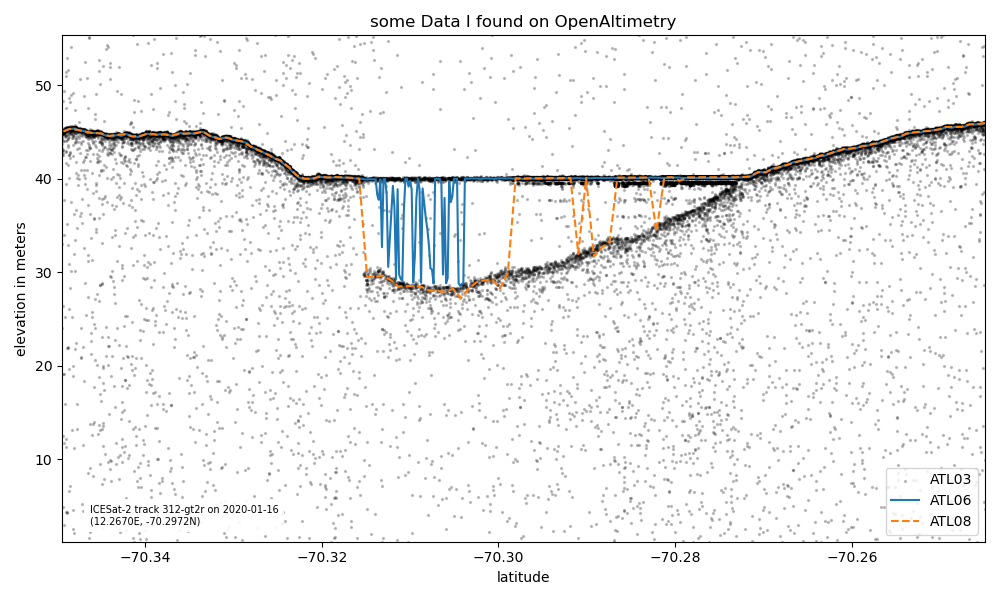

In [6]:
fig = is2data.plotData()

Let's wrap this all into a function!

In [ ]:
def plot_from_oa_url(url,gtx,title='ICESat-2 Data'):
    mydata = dataCollector(oaurl=url,beam=gtx)
    mydata.requestData()
    myplot = mydata.plotData(title=title)
    return (myplot, mydata)

## Examples

In [ ]:
%%capture
url = 'http://openaltimetry.org/data/api/icesat2/atl13?date=2020-12-15&minx=-77.858681&miny=25.728091&maxx=-77.831461&maxy=25.832559&trackId=1254&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt1r'
myplot, mydata = plot_from_oa_url(url=url, gtx=gtx, title='Coastal Example')
myplot.savefig('geemap_tutorial_exercise1.jpg', dpi=300)

In [ ]:
myplot

In [ ]:
%%capture
#use capture to prevent the plot
url = 'http://openaltimetry.org/data/api/icesat2/atl12?date=2021-12-15&minx=-154.32381980236076&miny=56.873762230836434&maxx=-154.29895036037468&maxy=56.93202651616244&trackId=1280&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt1r'
myplot, mydata = plot_from_oa_url(url=url, gtx=gtx, title='Alaska Coast')
myplot.savefig('geemap_tutorial_exercise1.jpg', dpi=300)

In [ ]:
myplot

In [ ]:
%%capture
url = 'http://openaltimetry.org/data/api/icesat2/atl03?date=2020-01-16&minx=12.107692195781404&miny=-70.34956862465471&maxx=12.426364789894341&maxy=-70.2449105354736&trackId=312&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt2r'
myplot, mydata = plot_from_oa_url(url=url, gtx=gtx, title='Lake Example')
myplot.savefig('geemap_tutorial_exercise1.jpg', dpi=300)

In [ ]:
myplot